In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette_hc = ['#ffffff', '#ddaa33', '#bb5566', '#004488', '#000000']

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

from tqdm.auto import tqdm

import time
import os
from collections import OrderedDict
import json
import pickle

import gc

import sys
sys.path.append("../")

from src.helpers import calculate_RMSE_balanced, calculate_RMSE, Timer, autoscaling, \
                        calculate_composite_RMSE_V_CaT, update_array_from_kwargs, get_value_by_key

In [2]:
def collect_genes_dict(config):

    genes_dict = {ec_name:
                  {p_name: dict(bounds = p['bounds'],
                                gamma  = p['gamma' ],
                                is_multiplier = p.get("is_multiplier", False))
                   for p_name, p in ec['params'].items() if isinstance(p, dict)}
                  for ec_name, ec in config['experimental_conditions'].items()}
    
    return OrderedDict(genes_dict)


def collect_constants_dict(config):

    constants_dict = {ec_name: {p_name: value for p_name, value in ec['params'].items() if isinstance(value, (int, float))}
                      for ec_name, ec in config['experimental_conditions'].items()}
    
    return OrderedDict(constants_dict)

In [3]:
idx = pd.IndexSlice

In [4]:
case_list = 'G3/C1/201224_215531', 'G3/C1/201224_210103', 'G3/C1/201223_220723', 
#case_list = 'G4/C8/201223_232912',
#case_list = 'G2/C2/201224_125711',
#case_list = 'G1/C1/201225_092709',

case_list = 'G3/C1/201223_220723', # 0.8
case_list = 'G3/C1/210113_133246', # 1.0

config_list = []
sol_list = []
columns_sol = []
tag_list = []

genes_all = {}

for case in tqdm(case_list):
    
    group, cell, suffix = case.split('/')
    group, cell = int(group[-1]), int(cell[-1])

    dirname_results = "../results/maleckar/voigt"
    cf = os.path.join(dirname_results, case, "config_backup.pickle")

    config_path = os.path.dirname(os.path.realpath(cf))

    with open(cf, 'rb') as f:
        config = pickle.load(f)

    config_list.append(config)

    #print(config['runtime']['output_folder_name'])
    
    dirname_report = os.path.join("images/maleckar/reports/", case)
    os.makedirs(dirname_report, exist_ok=True)

    # dict + dict
#     try:
#         genes = config['runtime']['genes_dict']
#     except:
#         genes = collect_genes_dict(config)
        
    genes = config['runtime']['genes_dict']


    #genes_all = {**genes_all, **genes}

    n_genes = sum(map(len, genes.values()))  

    dump = np.fromfile(os.path.join(config_path, "dump.bin"),
                       dtype=np.half,
                       )
    dump = dump.reshape(-1, n_genes + 1)
    dump = np.roll(dump, axis=1, shift=1)

#     try:
#         n_organisms = config['runtime']['n_organisms']
#     except:
#         n_organisms = config['n_organisms']

    n_organisms = config['runtime']['n_organisms']

    n_epochs = len(dump) // n_organisms

    columns_tuples = [('common', 'fitness')] + [(item[0], key) for item in genes.items() for key in item[1]]
    m_index_columns = pd.MultiIndex.from_tuples(columns_tuples)

    index_tuples = [(epoch, org) for epoch in range(n_epochs) for org in range(n_organisms)]
    m_index_index = pd.MultiIndex.from_tuples(index_tuples)

    dump = pd.DataFrame(dump, index=m_index_index, columns=m_index_columns)

    sol_list.append([(group, cell, suffix), genes, dump.loc[n_epochs-1, 0].values[1:]])

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
columns_tuples = []

for tag, genes, array in sol_list:
    for exp_cond in genes:
        for gene in genes[exp_cond]:
            t = (exp_cond, gene)
            if t not in columns_tuples:
                columns_tuples.append(t)
                
m_index = pd.MultiIndex.from_tuples(columns_tuples)

index_tuples = [x[0] for x in sol_list]
m_index_index = pd.MultiIndex.from_tuples(index_tuples)

df_sol = pd.DataFrame([[None for item in columns_tuples]] * len(sol_list),
                      columns=m_index, index=m_index_index)

for i, (case_index, genes, values) in enumerate(sol_list):
    columns_i = [(item[0], key) for item in genes.items() for key in item[1]]
    for j, c in enumerate(columns_i):
        df_sol.loc[case_index, c] = values[j]

In [6]:
#df_sol.T.to_csv("../../../Projects/Rheeda/G3C1.csv")

In [7]:
#c_list = (1, 3, '201209_000428'),
#for c in c_list:
    
df = df_sol.iloc[0]

print(df['common'], '\n - - - - - ')
print(df_sol.loc[:, idx[:, ['Na_i', 'K_i']]].stack())

P_Na         0.815918
g_Ca_L       0.370605
g_t          0.987305
g_kur        0.108093
g_K1         0.678223
g_Kr         0.141235
g_Ks         2.533203
g_B_Na       0.352295
g_B_Ca       0.484375
i_NaK_max    0.525879
i_CaP_max    2.548828
K_NaCa       2.068359
alpha_rel    8.687500
I_up_max     9.773438
Name: (3, 1, 201223_220723), dtype: object 
 - - - - - 
                              1032        2064       258         344  \
3 1 201223_220723 K_i   122.187500  123.687500  159.7500  124.312500   
                  Na_i    8.273438    7.558594   12.4375   10.960938   

                               516  
3 1 201223_220723 K_i   121.187500  
                  Na_i    9.820312  


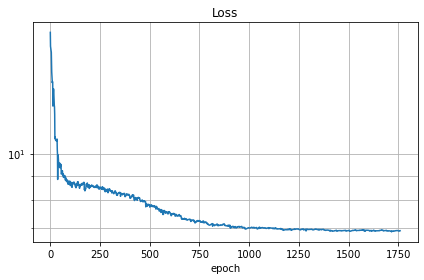

In [8]:
plt.semilogy(-dump['common', 'fitness'].loc[idx[:, 0]],
             #color=palette_hc[-2],
            )
plt.grid(which='both')
plt.title('Loss')
plt.xlabel('epoch')
plt.tight_layout()

dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)     

#plt.savefig(os.path.join(dirname, "loss.png"), dpi=600)

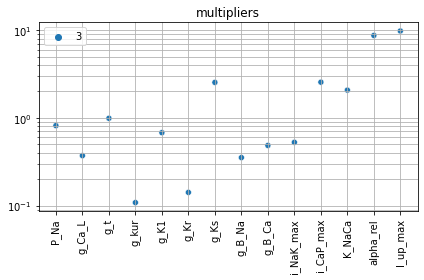

In [9]:
sns.scatterplot(data=df_sol['common'].T)
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.yscale('log')
plt.grid(which='both')
plt.title('multipliers')

plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_mults.png", dpi=300)

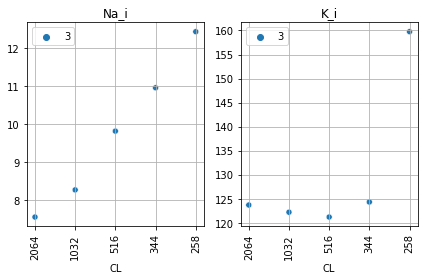

In [10]:
fig, axes = plt.subplots(ncols=2)

for i, item in enumerate(['Na_i', 'K_i']):
    plt.sca(axes[i])
    df = df_sol.loc[:, idx[:, item]].T.unstack().copy()
    df.index = df.index.astype('str')
    sns.scatterplot(data=df)
    plt.setp(plt.gca().get_xticklabels(), rotation=90)
    plt.grid()
    plt.title(item)
    plt.xlabel('CL')
    
plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_params.png", dpi=300)

In [8]:
phenotype_model = {}
phenotype_model_last = {}
gc.collect()


for exp_cond_name in tqdm(config['experimental_conditions']):
    
    if exp_cond_name == 'common':
        continue
    
    if True:
        index_col = ['epoch', 'index']
        usecols = index_col + ['V',
                               #'Cai1', 'Cai2', 'Cai3', 'Cai4', 'Cass',
                               #'Nai', 'Ki',
                               'Na_i', 'K_i',
                               ] 

        filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.csv")
        if os.path.isfile(filename):
            try:
                phenotype_model_last[exp_cond_name] = pd.read_csv(filename,
                                                                  #usecols=usecols
                                                                 )
                phen_len = len(phenotype_model_last[exp_cond_name])
            except pd.errors.EmptyDataError as e:
                print(f'{filename} is empty')
                continue

    
            if False:
                filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.bin")    
                phenotype_model[exp_cond_name] = np.fromfile(filename, dtype=np.float32).reshape(-1, len(config['runtime']['states_initial']))

                n_epochs = len(phenotype_model[exp_cond_name]) // phen_len

                m_index_tuples = [(epoch, index) for epoch in range(n_epochs) for index in range(phen_len)]
                m_index = pd.MultiIndex.from_tuples(m_index_tuples)

                phenotype_model[exp_cond_name] = pd.DataFrame(phenotype_model[exp_cond_name],
                                                              index=m_index,
                                                              columns=phenotype_model_last[exp_cond_name].columns)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
#dump.columns.levels

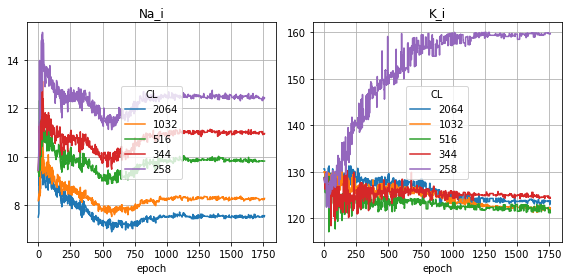

In [13]:
items = ['Na_i', 'K_i']


nrows = 1
ncols = len(items)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         #sharex='col', sharey='row',
                        )

for i, item in enumerate(items):
    plt.sca(axes[i])
    for column in dump:
        if item not in column:
            continue
        #max_epoch = dump.index[-1][0]
        #x_space = np.linspace(0, max_epoch, len(dump))
        plt.plot(dump.loc[idx[:, 0], column].values, label=column[0])
    plt.legend(title='CL', loc='center')
    plt.xlabel('epoch')
    plt.grid()
    plt.title(item)

dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

plt.tight_layout()
#plt.savefig(os.path.join(dirname, "concentrations.png"), dpi=600)

CL = 2064, rmse_V = 1.376e+00
CL = 1032, rmse_V = 1.212e+00
CL = 516, rmse_V = 1.234e+00
CL = 344, rmse_V = 1.274e+00
CL = 258, rmse_V = 1.813e+00


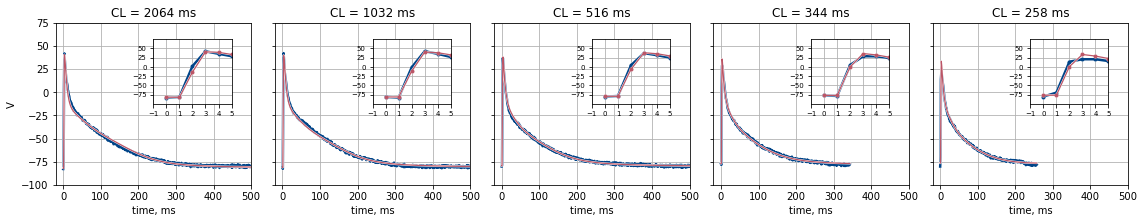

In [14]:
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']


nrows = 1
ncols = len(exp_cond_dict)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         sharex='col', sharey='row')

item = 'V'

for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

    ax = axes[i_cond]
    ax_inset = ax.inset_axes([0.5, 0.5, 0.4, 0.4])

    exp = exp_cond['phenotype']['V']
    model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
    
    exp, model = map(lambda x: np.roll(x, 1), [exp, model])

    rmse = calculate_RMSE(exp, model)

    ax.set_yticks(np.arange(-100, 75 + 1, 25))
    ax.set_ylim(-100, 75)

    print(f"CL = {exp_cond_name}, rmse_{item} = {rmse:.3e}")

    if i_cond == 0:
        ax.set_ylabel(item)
                
    for ml, ax_ in zip(['-', '.-'], [ax, ax_inset]):

        ax_.plot(exp, ml, color='w', lw=3)
        ax_.plot(exp, ml, color=palette_hc[3], lw=2.5, label='exp')

        ax_.plot(model, ml, color='w', lw=2)
        ax_.plot(model, ml, color=palette_hc[2], lw=1.25, label='model')

    ax.grid()

    ax.set_title(f'CL = {exp_cond_name} ms')
    ax.set_xlabel('time, ms')
    
    ax.set_xticks(np.arange(0, 750+1, 100))
    ax.set_xlim(-20, 500)
    
    
    ax_inset.set_xlim(-1, 5)
    ax_inset.set_ylim(ax.get_ylim())
    ax_inset.set_yticks(ax.get_yticks()[1:-1])
    ax_inset.set_xticks(np.arange(-1, 6, 1))
    ax_inset.tick_params(axis='both', labelsize='x-small')
    ax_inset.grid()

              
dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)               

fig.align_labels()
plt.tight_layout()
#plt.savefig(os.path.join(dirname, "waveforms.png"), dpi=600, facecolor='white')

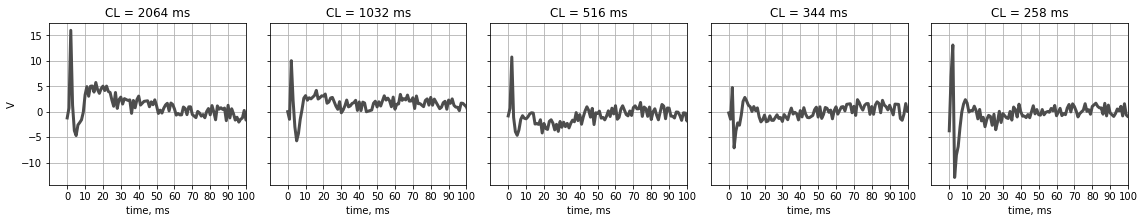

In [16]:
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']


nrows = 1
ncols = len(exp_cond_dict)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         sharex='col', sharey='row')

item = 'V'

for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

    ax = axes[i_cond]

    exp = exp_cond['phenotype']['V']
    model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
    
    exp, model = map(lambda x: np.roll(x, 1), [exp, model])

#     ax.set_yticks(np.arange(-100, 75 + 1, 25))
#     ax.set_ylim(-100, 75)

    if i_cond == 0:
        ax.set_ylabel(item)

    ax.plot(exp - model, '-', color='0.3', lw=3)

    ax.grid()

    ax.set_title(f'CL = {exp_cond_name} ms')
    ax.set_xlabel('time, ms')
    
    ax.set_xlim(-10, 100)
    ax.set_xticks(np.arange(0, 100+1, 10))


              
dirname = os.path.join("../images/maleckar/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

fig.align_labels()
plt.tight_layout()
#plt.savefig(os.path.join(dirname, "waveforms_diff.png"), dpi=600, facecolor='white')

In [241]:
import pyCardiac as pc

In [17]:
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']

m_index = pd.MultiIndex.from_product([[x[0] for x in exp_cond_dict],
                                      ['exp', 'model']], names=['CL', None])

df = pd.DataFrame(index=m_index, columns=['RP', 'APA', 'dVdt_max', 'APD80'])

for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):

    exp = exp_cond['phenotype']['V'].values
    model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
    
    df.loc[idx[exp_cond_name, :], 'RP'] = exp[-1], model[-1]
    df.loc[idx[exp_cond_name, :], 'APA'] = np.ptp(exp), np.ptp(model)
    df.loc[idx[exp_cond_name, :], 'dVdt_max'] = np.max(np.diff(exp)), np.max(np.diff(model))
    
    t = np.arange(len(exp))
    df.loc[idx[exp_cond_name, :], 'APD80'] = [pc.signal.analysis.calculate_APD(t, exp),
                                              pc.signal.analysis.calculate_APD(t, model)]

In [18]:
df

RP      APA dVdt_max APD80
CL                                         
2064 exp   -76.5991  124.512  69.2749    81
     model -78.9149  120.834  74.2281    83
1032 exp   -79.3457  124.512  71.7163    76
     model -80.1456  121.106  71.6751    78
516  exp   -79.3457  120.544  74.7681    70
     model -77.1663  117.223  77.6447    71
344  exp   -75.9888  122.375  76.5991    68
     model -75.1476  113.689  81.0579    65
258  exp   -74.4629  119.019  75.0732    62
     model -72.8826  109.619  83.6726    61

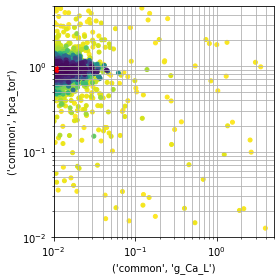

In [136]:
plt.figure(figsize=plt.figaspect(1))

name_x, name_y = ('common', 'g_Ca_L'), ('common', 'pca_tor')
#name_x, name_y = ('1032', 'K_i'), ('1032', 'Na_i')

epoch = 0

df = dump.loc[epoch][::-1]
#c = np.arange(len(df)) # np.log(-df['common', 'fitness'])

scat = plt.scatter(df[name_x], df[name_y], c=df.index, s=16)
line_best, = plt.plot(df[name_x].loc[0],
                      df[name_y].loc[0], 'Xr')

if genes[name_x[0]][name_x[1]].get('is_multiplier', False):
    plt.xscale('log')
if genes[name_y[0]][name_y[1]].get('is_multiplier', False):
    plt.yscale('log')

plt.xlabel(name_x)
plt.ylabel(name_y)

plt.xlim(genes[name_x[0]][name_x[1]]['bounds'])
plt.ylim(genes[name_y[0]][name_y[1]]['bounds'])

plt.grid(which='both')
plt.tight_layout()
#plt.gcf().align_labels()

dirname = os.path.join("../images/maleckar_tor/reports/", case, 'pairplots', "_".join(name_x + name_y))
os.makedirs(dirname, exist_ok=True)

for epoch in tqdm(range(0, dump.index[-1][0])):
    df = dump.loc[epoch][::-1]
    #c = np.arange(len(df)) # np.log(-df['common', 'fitness'])
    scat.set_offsets(df[[name_x, name_y]])
    scat.set_array(df.index)
    line_best.set_data(df[name_x].loc[0], df[name_y].loc[0])
    plt.savefig(os.path.join(os.path.join(dirname, f"pairplot_{epoch:04d}.png")), dpi=200)

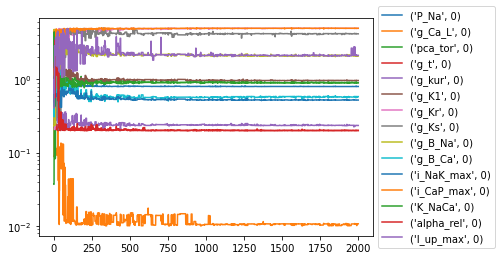

In [19]:
df = dump.loc[idx[:, 0], 'common'].unstack().iloc[:, 1:]

for key in df:
    plt.semilogy(df[key], label=key)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Prepare baselines

In [9]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os

import sys
sys.path.append("../")

from src.helpers import update_array_from_kwargs, get_value_by_key

dirname = '../src/model_ctypes/_maleckar/'
filename_so = os.path.join(dirname, 'maleckar.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

# void computeRates(double VOI, double* CONSTANTS, double* RATES, double* STATES, double* ALGEBRAIC)
model.computeRates.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.computeRates.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')#,
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.run.restype = ctypes.c_int



model.run_chain.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
]

model.run_chain.restype = ctypes.c_int



legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']

In [10]:
# S = np.zeros(len(legend_states)) #  np.loadtxt("S.txt")
# C = np.zeros(len(legend_constants)) #  np.loadtxt("C.txt")

# model.initialize_states_default(S)
# model.initialize_constants_default(C)

In [11]:
S = legend_states.copy()
C = legend_constants.copy()

In [12]:
A = np.zeros(70)
R = np.zeros_like(S)

In [13]:
model.computeRates(0, C.values, R, S.values, A)

4602678819172646912

In [14]:
R

array([ 1.49975933e+04,  6.43886446e-02, -8.96699945e-03, -1.58265796e-02,
        7.46660127e-03,  2.88394704e-02,  2.63921851e-04, -1.98109262e-04,
        1.93273746e-05,  1.67571015e-04, -1.27249964e-01,  1.33617859e+00,
        2.28407303e-04,  1.43955565e-03, -3.53839028e-05,  8.91755074e-03,
       -5.37258284e-03,  1.08786599e-05,  2.27877381e-02,  1.01978103e-02,
       -8.85740000e-02, -3.52745120e-02, -1.92514000e-02,  7.64200000e-03,
       -9.88801496e-03, -8.83018650e-03, -3.15072477e-02, -5.63630928e-03,
        3.33238143e-01, -1.50929837e-04])

In [15]:
def create_C_S(organism, config, exp_cond_name):

    legend = config['runtime']['legend']
    genes_dict = config['runtime']['genes_dict']
    constants_dict = config['runtime']['constants_dict']

    genes_current = organism['genes'][['common', exp_cond_name]]
    constants_dict_current = {**constants_dict['common'],
                              **constants_dict[exp_cond_name],
                             }
    
    C = legend['constants'].copy()
    S = organism['state'][exp_cond_name].copy()

    for i in range(len(genes_current)):
        g_name = genes_current.index.get_level_values(1).to_list()[i]

        if g_name in legend['constants'].index:
            for ecn in ['common', exp_cond_name]:
                if g_name in genes_dict[ecn]:
                    if genes_dict[ecn][g_name]['is_multiplier']:
                        C[g_name] *= genes_current[ecn, g_name]
                    else:
                        C[g_name] = genes_current[ecn, g_name]

        if g_name in legend['states'].index:
            for ecn in ['common', exp_cond_name]:
                if g_name in genes_dict[ecn]:
                    if genes_dict[ecn][g_name]['is_multiplier']:
                        S[g_name] *= genes_current[ecn, g_name]
                    else:
                        S[g_name] = genes_current[ecn, g_name]

    for c_name, c in constants_dict_current.items():
        print(c_name, c)
        if c_name in legend['constants'].index:
            C[c_name] = c
        if c_name in legend['states'].index:
            S[c_name] = c

    return C, S

In [594]:
genes = dump.loc[(idx[:, 0]), :].iloc[-1]

state = pd.DataFrame({exp_cond_name: phenotype_model_last[exp_cond_name].iloc[-1]
         for exp_cond_name in config['experimental_conditions'] if exp_cond_name != 'common'})

C, S = create_C_S(dict(genes=genes, state=state), config, '1032')

stim_amplitude -60
stim_duration 0.001
Mg_i 1.0
Na_b 140
Ca_b 2.0
K_b 4
stim_period 1.032


In [196]:
C['g_K1'] *= 0.5
C['P_Na'] *= 0.6
C['g_Ca_L'] *= 0.5
#P_Ca_L_ToR_ORd*0.5

In [197]:
# C['stim_amplitude'] *= 2
# C['stim_amplitude']

In [62]:
S = legend_states.copy()
C = legend_constants.copy()

In [146]:
C['stim_amplitude'] = -180

In [83]:
C['stim_period'] = 1
C['stim_duration'] = 0.001
C['stim_amplitude'] = -60
C['pca_tor'] = 0 # 5e-5 * 4
C['g_Ca_L'] = 3 * 6.75

In [198]:
C['stim_period'] = 1

In [184]:
C.to_csv("../../../projects/Rheeda/G3C1/andrey_constants.csv")

In [199]:
t_sampling = 0.001 # 0.001

stim_period = C['stim_period'] # C[config['stim_period_legend_name']]
#stim_period = get_value_by_key(C, legend_constants, 'stim_period')
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-6

chain_length = 200
v_threshold = 1e-1
t_safe = 5e-2

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
#output_A = np.zeros((n_samples_per_stim * n_beats + 1, 107))
#output_t = np.zeros((n_samples_per_stim * n_beats + 1))

# 2D

In [802]:
#@njit
def calculate_diffusion(V, g_gap_junc_tensor):
        
    I = np.zeros_like(V)
    
    #indices = np.array(list(map(np.arange, V.shape)), dtype=object)
    
    for axis in range(V.ndim):

        indices_next, indices_prev = [slice(None)] * 3, [slice(None)] * 3
        indices_next[axis] = slice(1, None)        
        indices_prev[axis] = slice(0, -1)
        indices_next = tuple(indices_next)
        indices_prev = tuple(indices_prev)

        I[indices_next] = I[indices_next] - g_gap_junc_tensor[axis] * (V[indices_prev] - V[indices_next])
        I[indices_prev] = I[indices_prev] - g_gap_junc_tensor[axis] * (V[indices_next] - V[indices_prev])
            
    return I

In [803]:
#C['P_Na'] = 1.8e-3 #6e-3

In [820]:
def is_pacing_condition(t, ix, iy, iz, SIZE):
    
    X_SIZE, Y_SIZE, Z_SIZE = SIZE
    
    #pacing_condition = ix == iy == iz == 0
#     pacing_condition = (ix == X_SIZE // 2) \
#                      & (iy == Y_SIZE // 2) \
#                      & (iz == 0)#Z_SIZE // 2)

    pacing_condition =  (X_SIZE / 2 - 5 <= ix <= X_SIZE / 2 + 5)
    pacing_condition &= (Y_SIZE / 2 - 5 <= iy <= Y_SIZE / 2 + 5)
    pacing_condition &= (iz == 0)

    pacing_condition &= t < 5e-3
    
    return pacing_condition

In [821]:
from multiprocessing import Pool

In [858]:
dt = 1e-5

t_end = 2e-2
t_sampling = 1e-4

sigma_l = 0.126  # S/m
h = 100  # um

g_gap_junc = sigma_l * h # 5.0
g_gap_junc_tensor = [g_gap_junc,
                     g_gap_junc / 5,
                     g_gap_junc / 5]

N = int(t_end / dt)
step_print = int(t_sampling / dt)


X_SIZE, Y_SIZE, Z_SIZE = 61, 31, 31
SIZE = X_SIZE, Y_SIZE, Z_SIZE

S_tissue = np.tile(S.values, (*SIZE, 1))
C_tissue = np.tile(C.values, (*SIZE, 1))
C_tissue[:, :, :, 7] = 0
R_tissue = np.zeros_like(S_tissue)
A_tissue = np.tile(A, (*SIZE, 1))

result = np.zeros((*SIZE, int(t_end / t_sampling)))
i_print = 0
t = 0

In [859]:
def f(x):
    t, C, R, S, A = x
    model.computeRates(t, C, R, S, A)
    
    return R

In [860]:
IS_PARALLEL = False

for it in tqdm(range(N)):
    
    if it % step_print == 0:
        result[:, :, :, i_print] = S_tissue[:, :, :, 0]
        i_print += 1
        
    if IS_PARALLEL:

        C_tissue[X_SIZE // 2 - 5: X_SIZE // 2 + 5,
                 Y_SIZE // 2 - 5: Y_SIZE // 2 + 5,
                 0, 7] = -300 if t < 5e-3 else 0 

        args = zip([t] * (X_SIZE * Y_SIZE * Z_SIZE),
                   C_tissue.reshape(-1, C_tissue.shape[-1]),
                   R_tissue.reshape(-1, R_tissue.shape[-1]),
                   S_tissue.reshape(-1, S_tissue.shape[-1]),
                   A_tissue.reshape(-1, A_tissue.shape[-1]))

        with Pool(2) as p:
            R_list = p.map(f, args)

        R_tissue = np.array(R_list).reshape(R_tissue.shape)
        
    else:

        for ix in range(X_SIZE):
            for iy in range(Y_SIZE):
                for iz in range(Z_SIZE):

                    stim_amplitude = -300
                    C['stim_amplitude'] = stim_amplitude if is_pacing_condition(t, ix, iy, iz, SIZE) else 0

                    model.computeRates(t,
                                       C.values,
                                       R_tissue[ix, iy, iz],
                                       S_tissue[ix, iy, iz],
                                       A.copy())

    V = S_tissue[:, :, :, 0]
    assert not np.any(np.isnan(V))
    I_gap_junc = calculate_diffusion(V, g_gap_junc_tensor)
    
    R_tissue[:, :, :, 0] = R_tissue[:, :, :, 0] - I_gap_junc * 1000
    
    S_tissue = S_tissue + dt * R_tissue            
    t += dt

  0%|          | 0/1999 [00:00<?, ?it/s]

In [861]:
# args = zip([t] * (X_SIZE * Y_SIZE * Z_SIZE),
#     C_tissue.reshape(-1, C_tissue.shape[-1]),
#     R_tissue.reshape(-1, R_tissue.shape[-1]),
#     S_tissue.reshape(-1, S_tissue.shape[-1]),
#     A_tissue.reshape(-1, A_tissue.shape[-1]))

# with Pool(2) as p:
#     result = p.map(f, args)

In [862]:
ixc, iyc, izc = map(lambda x: int(x // 2), SIZE)
ic = ixc, iyc, izc

In [863]:
(33 - 15) / 4

4.5

In [883]:
#np.save("./result_61_31_31_300_5", result)

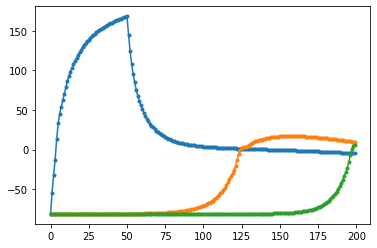

In [881]:
plt.plot(result[ixc, iyc, 0], '.-')
plt.plot(result[ic], '.-')
plt.plot(result[ixc, iyc, -5], '.-')

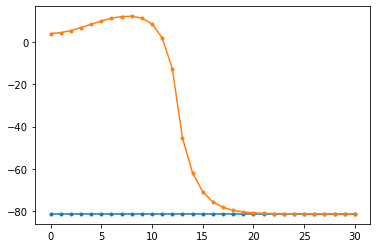

In [865]:
plt.plot(result[ixc, iyc, :, 0], '.-')
plt.plot(result[ixc, iyc, :, 100], '.-')

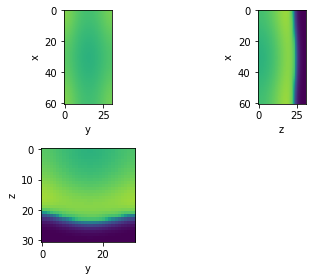

In [877]:
fig, axes = plt.subplots(2, 2,
                        #sharex='col', sharey='row',
                        )

t = 180

axes[0, 0].imshow(result[:, :, 0, t],
           vmin=-80, vmax=40,
           #aspect=10,
          )
axes[0, 0].set_xlabel('y')
axes[0, 0].set_ylabel('x')

axes[0, 1].imshow(result[:, iyc, :, t],
           vmin=-80, vmax=40,
           #aspect=10,
          )

axes[0, 1].set_xlabel('z')
axes[0, 1].set_ylabel('x')

axes[1, 0].imshow(result[ixc, :, :, t].T,
           vmin=-80, vmax=40,
           #aspect=10,
          )

axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('z')

axes[1, 1].set_visible(False)

plt.tight_layout()

In [ ]:
sol = solve_ivp(model.computeRates, y0=S,
                t_span=t_span, t_eval=t_eval,
                args=(C, R, A),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling)

In [39]:
status = model.run_chain(S.values.copy(), C.values.copy(),
                         chain_length, v_threshold, t_safe,
                         n_beats, t_sampling, tol, output)

print(status)

2


In [200]:
status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

print(status)

2


In [201]:
#output = np.loadtxt(os.path.join(dirname, "output.txt"))

In [202]:
output = pd.DataFrame(output, columns=legend_states.index)

In [203]:
output[:10]

name,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,f_L2,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,-81.229237,139.959082,8.273438,0.001371,9.651567e-01,0.963456,0.000027,0.000004,0.999490,0.999484,...,0.010674,0.005109,0.164216,0.626991,1.376686,0.267990,0.267668,0.243337,0.550704,0.000126
1,-15.943658,139.956263,8.273821,0.636356,7.991732e-01,0.934235,0.000029,0.003726,0.996769,0.999119,...,0.010765,0.005146,0.164227,0.626992,1.376695,0.267990,0.268022,0.243336,0.551065,0.000126
2,24.956378,139.931623,8.277173,0.998202,2.935029e-02,0.670242,0.000791,0.333678,0.905820,0.984013,...,0.011098,0.005285,0.164310,0.626950,1.376735,0.268004,0.269523,0.243337,0.551393,0.000159
3,26.377918,139.930947,8.277266,0.998530,1.046876e-03,0.480249,0.002358,0.590870,0.819669,0.968427,...,0.011444,0.005436,0.164431,0.626868,1.376782,0.267833,0.271524,0.243331,0.550037,0.001858
4,23.164677,139.931818,8.277148,0.997846,3.739926e-05,0.344114,0.004133,0.747670,0.741727,0.953090,...,0.012191,0.005753,0.164680,0.626733,1.376880,0.261763,0.275427,0.242699,0.542231,0.009853
5,18.432431,139.932931,8.276997,0.996186,1.479924e-06,0.246568,0.005950,0.841464,0.671251,0.938004,...,0.016504,0.007536,0.165891,0.626158,1.377411,0.227383,0.293364,0.236832,0.525724,0.026132
6,13.432465,139.933842,8.276874,0.993019,4.279774e-07,0.176674,0.007735,0.895079,0.607592,0.923175,...,0.029248,0.012901,0.169715,0.624072,1.379025,0.161300,0.343164,0.217789,0.500935,0.049916
7,8.725387,139.934424,8.276795,0.987685,9.416222e-07,0.126593,0.009427,0.921123,0.550207,0.908618,...,0.048562,0.021365,0.176619,0.619713,1.381676,0.099730,0.420847,0.185969,0.469071,0.079406
8,4.467771,139.934826,8.276741,0.979488,2.142692e-06,0.090712,0.010975,0.925347,0.498680,0.894360,...,0.066485,0.029742,0.185199,0.613679,1.384526,0.060558,0.507597,0.150023,0.433026,0.111294
9,0.666670,139.935220,8.276688,0.967792,4.481241e-06,0.065006,0.012334,0.909492,0.452756,0.880461,...,0.078082,0.035738,0.193932,0.607136,1.386925,0.038138,0.589802,0.116875,0.396012,0.142534


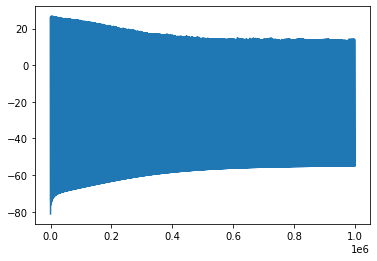

In [204]:
plt.plot(output.V)

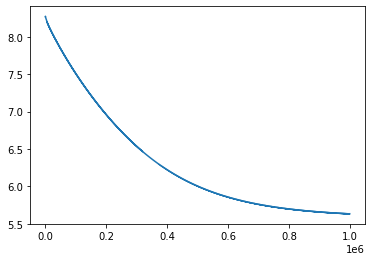

In [205]:
plt.plot(output.Na_i)

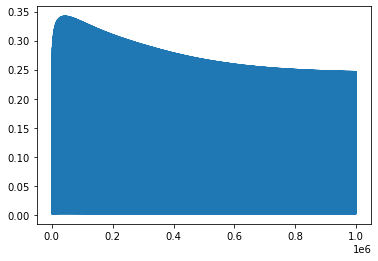

In [206]:
plt.plot(output.Ca_rel)

In [207]:
#output.to_csv("../../../projects/Rheeda/G3C1/andrey_normal.csv", index=False)

In [208]:
tail = output[-1000 * 10 - 1:].reset_index()

In [209]:
tail

name,index,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,990000,-55.024745,140.021349,5.633908,0.032331,0.164876,0.158473,0.000055,0.000358,0.979689,...,0.009905,0.004740,0.154520,0.634265,1.375071,0.246570,0.247918,0.228319,0.522022,0.000090
1,990001,11.169576,140.017669,5.634408,0.986784,0.037737,0.134569,0.000143,0.097267,0.944823,...,0.009963,0.004763,0.154520,0.634270,1.375075,0.246578,0.248145,0.228323,0.522408,0.000091
2,990002,13.269086,140.016601,5.634553,0.992760,0.001347,0.096423,0.001218,0.417354,0.855242,...,0.010079,0.004812,0.154543,0.634258,1.375088,0.246587,0.248714,0.228328,0.522627,0.000256
3,990003,11.979645,140.016928,5.634508,0.991589,0.000049,0.069091,0.002852,0.620633,0.774190,...,0.010205,0.004867,0.154579,0.634236,1.375104,0.246059,0.249458,0.228294,0.520073,0.003156
4,990004,9.642786,140.017446,5.634438,0.988886,0.000003,0.049506,0.004627,0.744745,0.700956,...,0.011123,0.005244,0.154821,0.634135,1.375214,0.236759,0.253438,0.227148,0.510471,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,999996,-55.017970,140.020334,5.631853,0.032357,0.164676,0.158123,0.000055,0.000358,0.979657,...,0.009901,0.004738,0.154499,0.634280,1.375067,0.246396,0.247804,0.228193,0.520465,0.000090
9997,999997,-55.018539,140.020317,5.631856,0.032354,0.164697,0.158181,0.000055,0.000358,0.979662,...,0.009901,0.004737,0.154484,0.634291,1.375065,0.246401,0.247795,0.228197,0.520852,0.000090
9998,999998,-55.019102,140.020300,5.631858,0.032352,0.164717,0.158239,0.000055,0.000358,0.979666,...,0.009900,0.004737,0.154470,0.634302,1.375062,0.246407,0.247785,0.228202,0.521240,0.000090
9999,999999,-55.019658,140.020283,5.631860,0.032350,0.164738,0.158297,0.000055,0.000358,0.979671,...,0.009900,0.004737,0.154456,0.634313,1.375060,0.246412,0.247776,0.228206,0.521627,0.000090


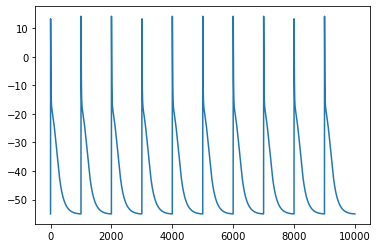

In [210]:
plt.plot(tail.V)

In [211]:
tail.to_csv("../../../projects/Rheeda/G3C1/andrey_fibrosis.csv", index=False)

In [212]:
tail

name,index,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,990000,-55.024745,140.021349,5.633908,0.032331,0.164876,0.158473,0.000055,0.000358,0.979689,...,0.009905,0.004740,0.154520,0.634265,1.375071,0.246570,0.247918,0.228319,0.522022,0.000090
1,990001,11.169576,140.017669,5.634408,0.986784,0.037737,0.134569,0.000143,0.097267,0.944823,...,0.009963,0.004763,0.154520,0.634270,1.375075,0.246578,0.248145,0.228323,0.522408,0.000091
2,990002,13.269086,140.016601,5.634553,0.992760,0.001347,0.096423,0.001218,0.417354,0.855242,...,0.010079,0.004812,0.154543,0.634258,1.375088,0.246587,0.248714,0.228328,0.522627,0.000256
3,990003,11.979645,140.016928,5.634508,0.991589,0.000049,0.069091,0.002852,0.620633,0.774190,...,0.010205,0.004867,0.154579,0.634236,1.375104,0.246059,0.249458,0.228294,0.520073,0.003156
4,990004,9.642786,140.017446,5.634438,0.988886,0.000003,0.049506,0.004627,0.744745,0.700956,...,0.011123,0.005244,0.154821,0.634135,1.375214,0.236759,0.253438,0.227148,0.510471,0.012895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,999996,-55.017970,140.020334,5.631853,0.032357,0.164676,0.158123,0.000055,0.000358,0.979657,...,0.009901,0.004738,0.154499,0.634280,1.375067,0.246396,0.247804,0.228193,0.520465,0.000090
9997,999997,-55.018539,140.020317,5.631856,0.032354,0.164697,0.158181,0.000055,0.000358,0.979662,...,0.009901,0.004737,0.154484,0.634291,1.375065,0.246401,0.247795,0.228197,0.520852,0.000090
9998,999998,-55.019102,140.020300,5.631858,0.032352,0.164717,0.158239,0.000055,0.000358,0.979666,...,0.009900,0.004737,0.154470,0.634302,1.375062,0.246407,0.247785,0.228202,0.521240,0.000090
9999,999999,-55.019658,140.020283,5.631860,0.032350,0.164738,0.158297,0.000055,0.000358,0.979671,...,0.009900,0.004737,0.154456,0.634313,1.375060,0.246412,0.247776,0.228206,0.521627,0.000090


In [161]:
err_abs = output.iloc[-1] - output.iloc[0]
err_rel = err_abs / output.iloc[0] * 100

In [24]:
items = ['Na_i', 'K_i', 'V', 'Ca_i']
df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Na_i,K_i,V,Ca_i
err_rel,0.045314,-0.003044,-0.015655,-1.836484e-02
err_abs,0.003749,-0.003720,0.012717,-4.715196e-09


In [383]:
with open("./cases/koivumaki/invalid.pickle", 'rb') as f:
    invalid = pickle.load(f)

In [384]:
invalid['genes']

ec_name  g_name                
common   PNa                         0.115469
         gCaL                        0.357668
         gt                          0.580297
         gKur                        4.419772
         gK1                         8.274927
         gKr                         1.502725
         gKs                         0.287927
         gNab                        4.446609
         gCab                        1.133524
         INaKmax                     0.473646
         ICaPmax                     1.363152
         gIf                         1.376925
         kNaCa                       7.980599
         Jrel_multiplier             0.266783
         J_SERCASR_multiplier        0.101856
         J_bulkSERCA_multiplier      0.120808
         kSRleak                     8.975239
2064     Nai                         7.855845
         Ki                        142.343470
1032     Nai                        16.340855
         Ki                        143.926869
51

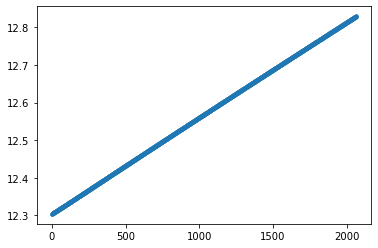

In [265]:
plt.plot(invalid['phenotype'][0]['Nai'], '.-')

In [73]:
np.max(np.diff(config['experimental_conditions'][1]['phenotype'][:, 0]))

67.138671875

In [74]:
np.max(np.diff(phenotype_model[1032]['V']))

109.55

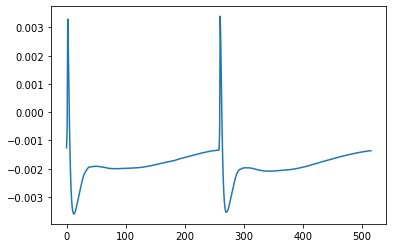

In [75]:
plt.plot(output[-2 * CL -1: -1, 23] - output[-3 * CL -1 : -1 * CL -1 :, 23])

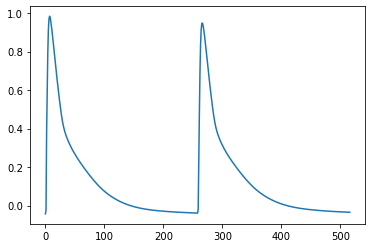

In [76]:
plt.plot(output[: 2 * CL + 1, 23] - output[-2 * CL - 1:, 23])

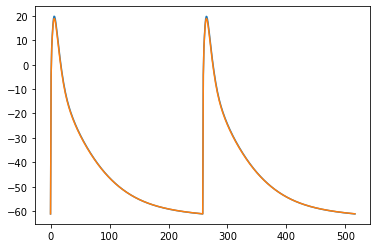

In [77]:
plt.plot(output[: 2 * CL + 1, 23])
plt.plot(output[-2 * CL - 1:, 23])

In [78]:
output = output[-CL - 1:]
print(output.shape)

(259, 43)


In [148]:
S = output[-1]
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/states/state_{CL}.txt", S)

In [150]:
V = output[:, 23]
Ca_i_mean = output.T[4: 9].mean(axis=0)
phenotype = np.vstack([V, Ca_i_mean]).T
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype)

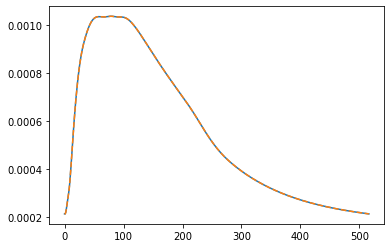

In [156]:
Ca_i_mean = output.T[4: 9].mean(axis=0)
Ca_i_sum  = output.T[4: 9].sum(axis=0)
plt.plot(Ca_i_mean)
plt.plot(Ca_i_sum / 5, '--')

In [165]:
for CL in [2000, 1500, 1000, 500, 333, 250, 200, 166]:
    phenotype = np.loadtxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt")
    np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype.T)

In [158]:
len(phenotype)

2

In [163]:
a = np.loadtxt("./cases/maleckar/v0/baselines/V_Ca_i_1000.txt")

In [164]:
a.shape

(1000, 2)

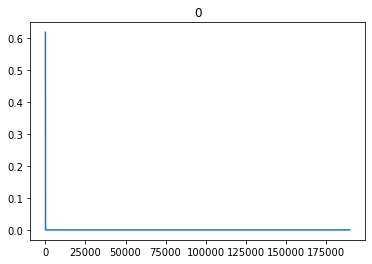

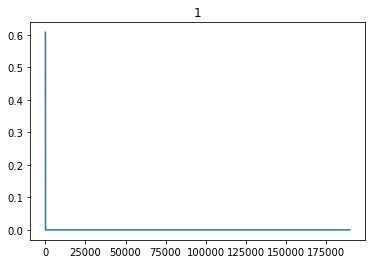

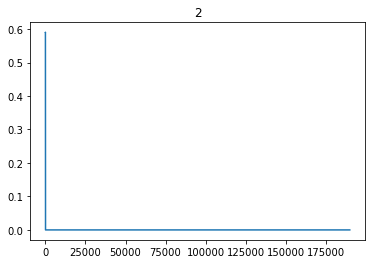

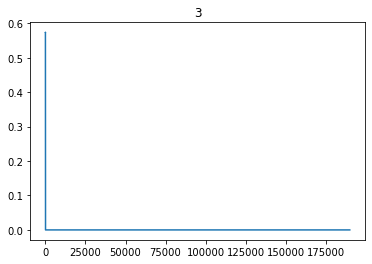

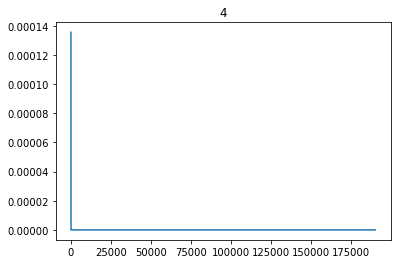

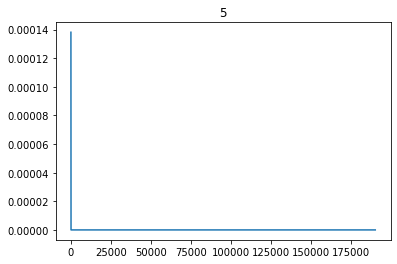

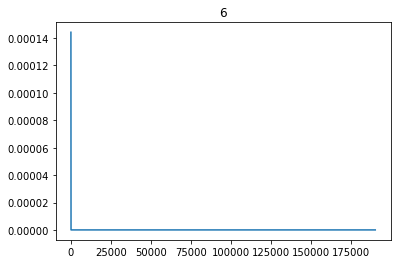

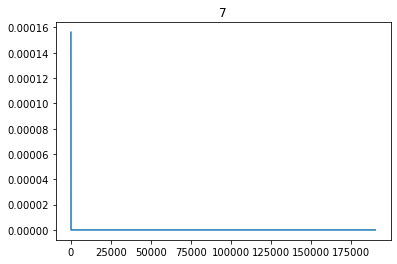

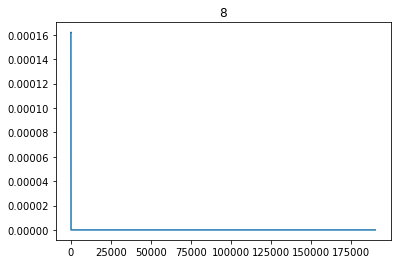

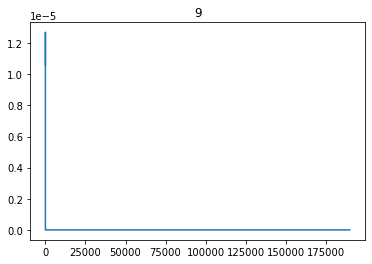

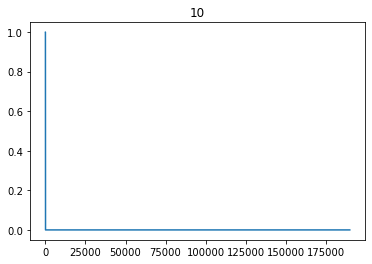

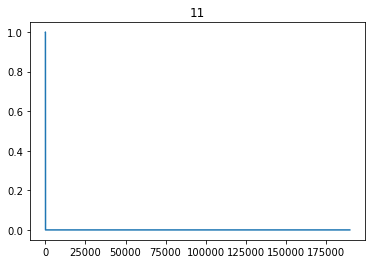

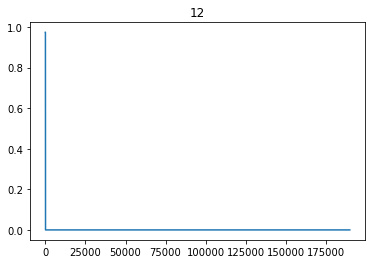

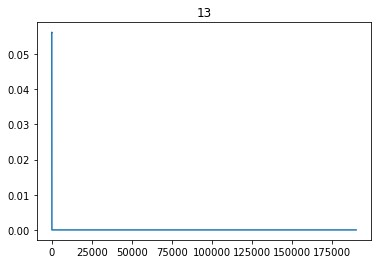

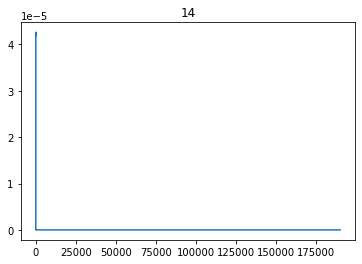

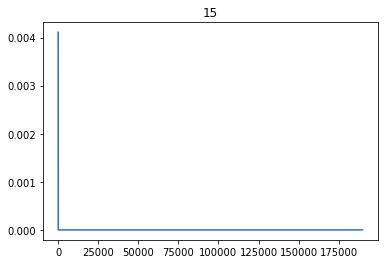

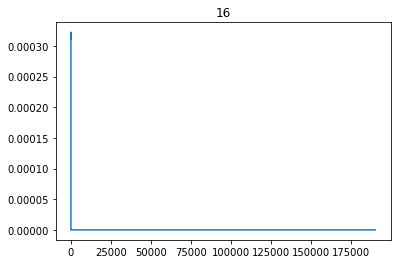

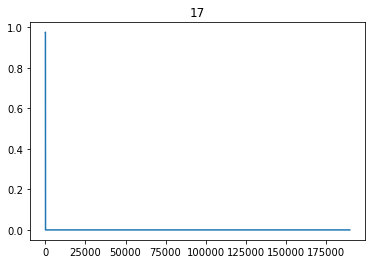

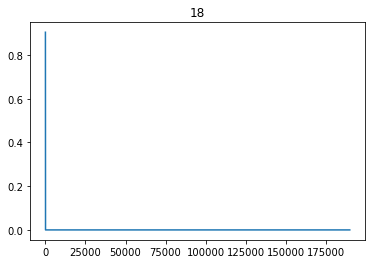

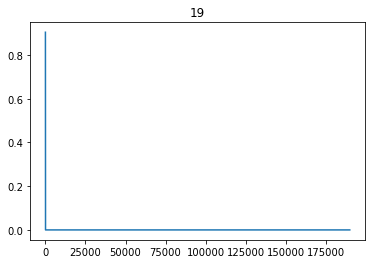

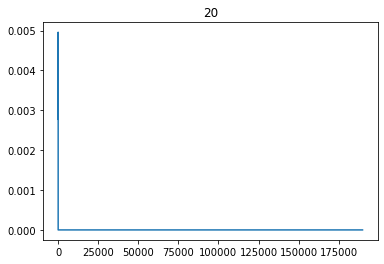

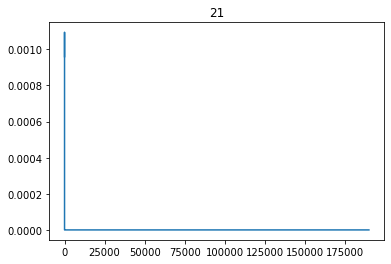

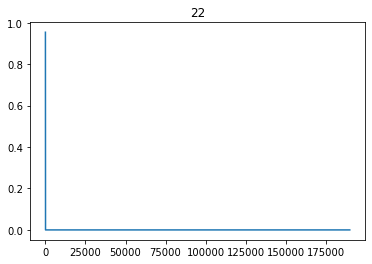

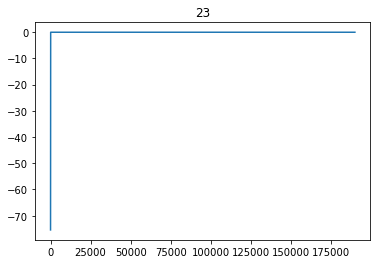

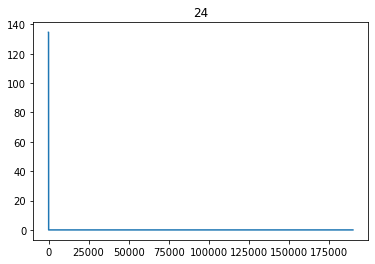

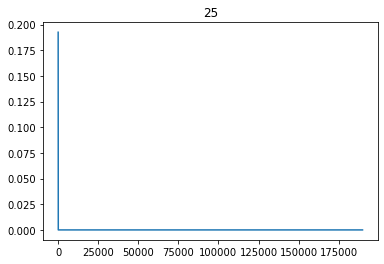

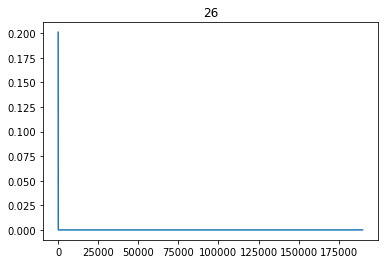

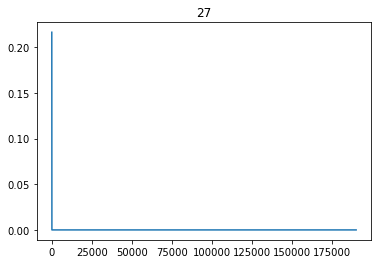

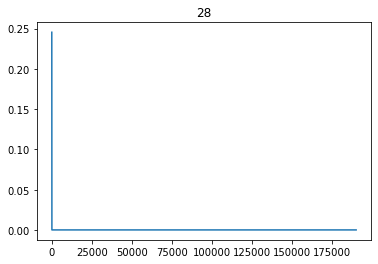

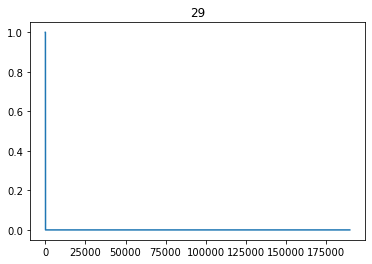

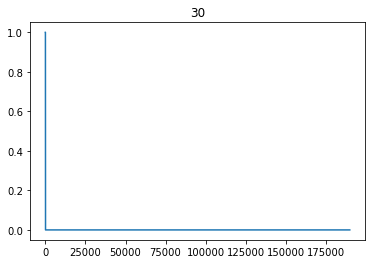

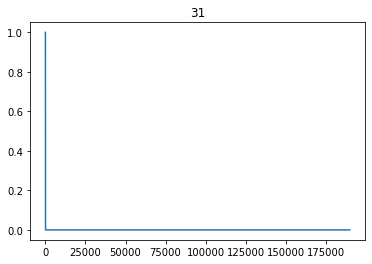

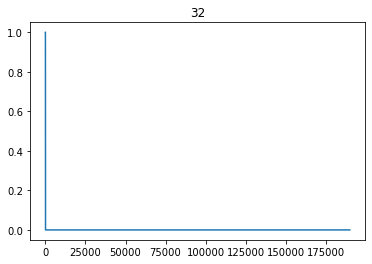

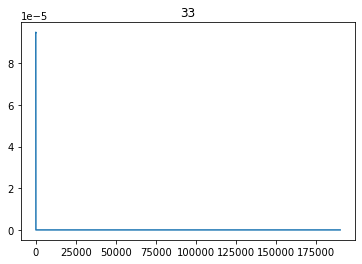

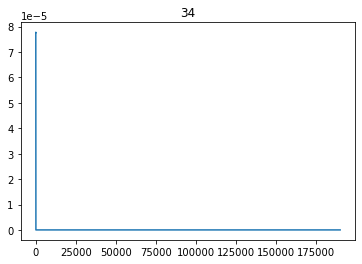

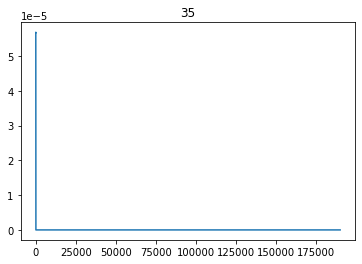

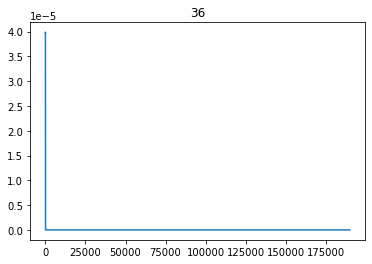

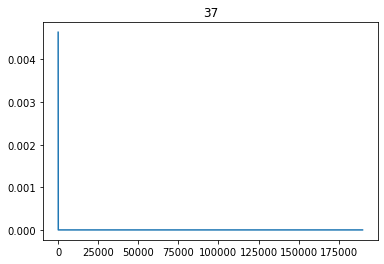

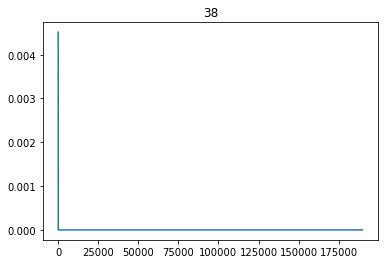

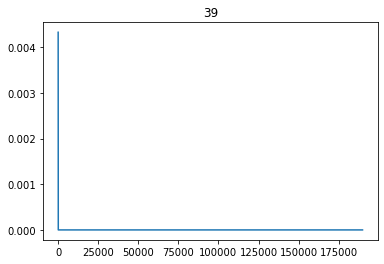

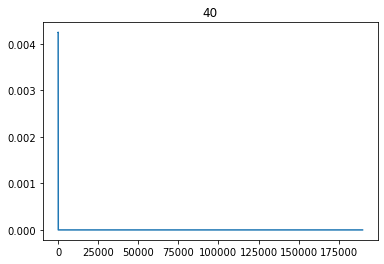

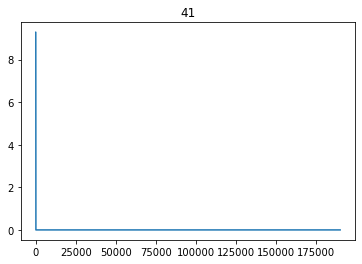

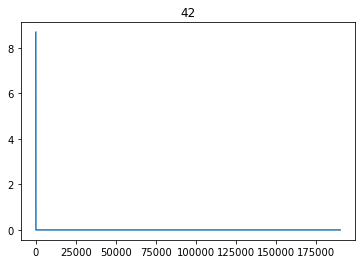

In [6]:
for i in range(output.shape[-1]):
    plt.title(str(i))
    plt.plot(output[:, i])
    plt.show()

# Voigt

71.71630859375


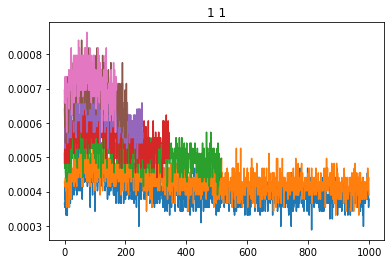

74.462890625


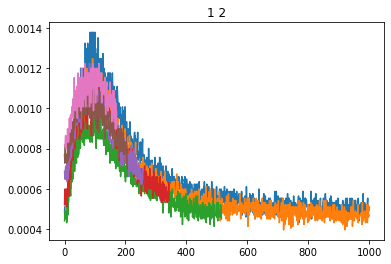

67.138671875


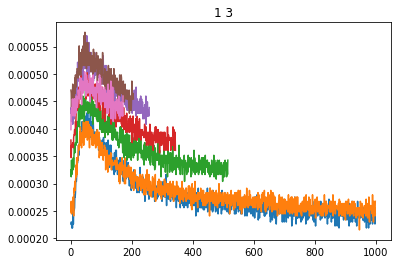

57.67822265625


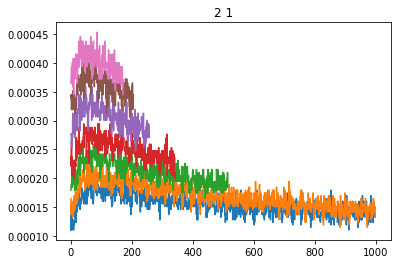

65.00244140625


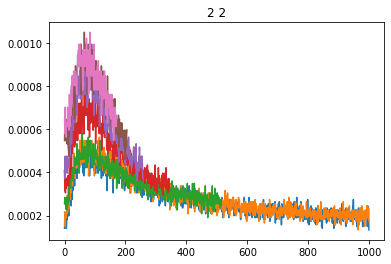

95.21484375


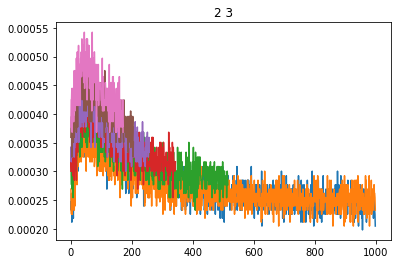

76.59912109375


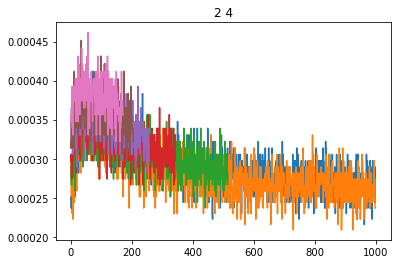

81.48193359375


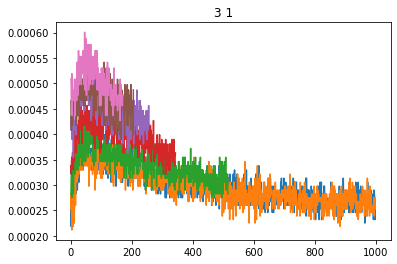

88.5009765625


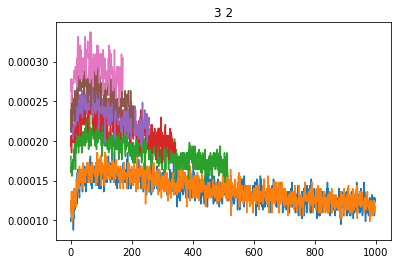

59.2041015625


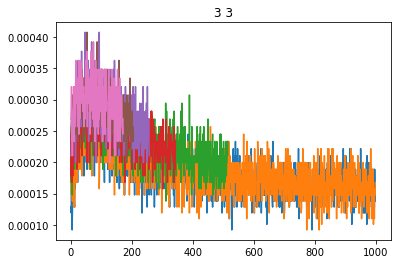

133.36181640625


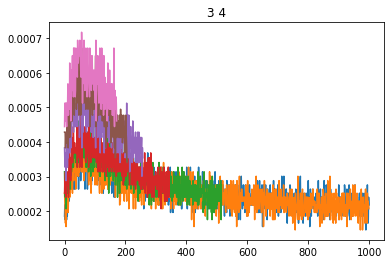

87.58544921875


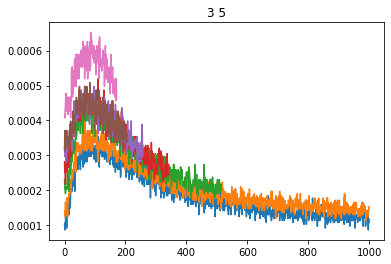

86.669921875


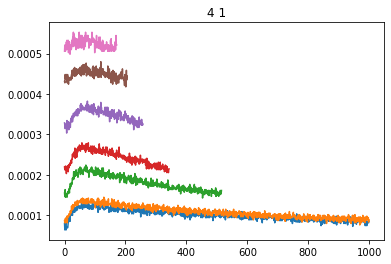

107.421875


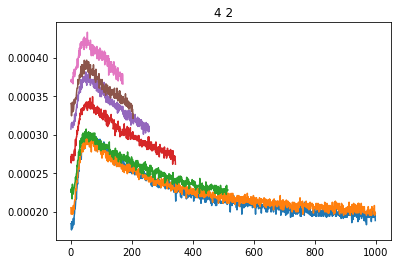

66.5283203125


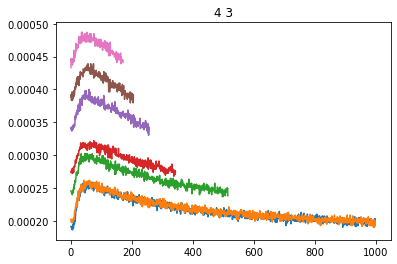

92.46826171875


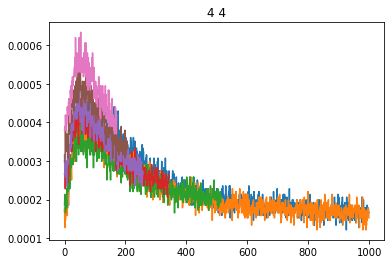

84.53369140625


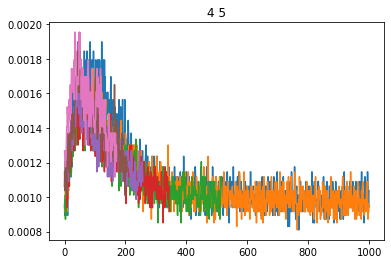

86.97509765625


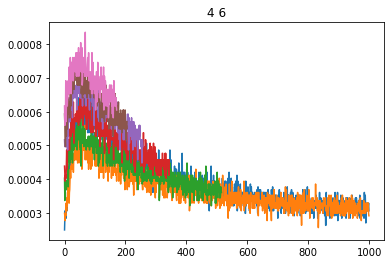

79.9560546875


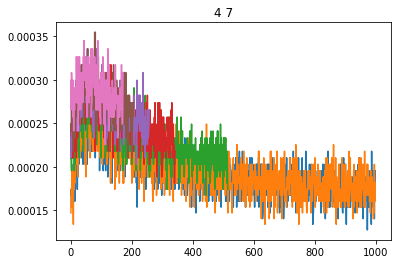

72.93701171875


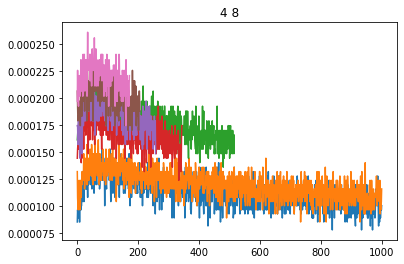

In [370]:
group_indices = range(1, 4 + 1)
cell_indices = [3, 4, 5, 8]

CL_list = [2064, 1032, 516, 344, 258, 206, 172]

df_CaT = pd.read_csv("/home/andrey/Dropbox/Voigt/voigt_CaT_params.csv")
df_CaT.set_index(['Group', 'Cell'], inplace=True)

dV_list = []

for ig in group_indices:
    for ic in range(1, cell_indices[ig-1] + 1):
        for CL in CL_list:
            sweep = np.loadtxt(f"../../Data/Voigt/Action_potentials_AG_Voigt/chosen_sweeps/{ig}_{ic}_{CL}.txt")
            phenotype = sweep[::10, [0, 2]]
                        
            FBL, Fmax = df_CaT.loc[(ig, ic), :]
            K = 864 / 1000. / 1000. # mM
            F = phenotype[:, 1]
            cat = K * (F - FBL) / (Fmax - F)
            
            phenotype[:, 1] = cat
            
            v = phenotype[:, 0]
            v = np.clip(v, a_min=None, a_max=np.max(v[2:]))
            phenotype[:, 0] = v

            phenotype = phenotype[:1000]
            
            #break
            #phenotype = pd.DataFrame(['V', 'Ca_i']
            dirsave = f"/home/andrey/WORK/Reentry/pypoptim/data/voigt/G{ig}/C{ic}/phenotypes"
            if not os.path.isdir(dirsave):
                os.makedirs(dirsave)
            #np.savetxt(os.path.join(dirsave, f"V_CaT_{CL}.txt"), phenotype)
            pd.DataFrame(phenotype, columns=['V', 'Cai']).to_csv(os.path.join(dirsave, f"phenotype_{CL}.csv"), index=False)
            # v = v.reshape(-1, 10).mean(axis=1)
            plt.plot(phenotype[:, 1])
            
            if CL == 1032:
                dV_max = np.max(np.diff(phenotype[:, 0]))
                dV_list.append(dV_max)
                print(dV_max)
            
        plt.title(f'{ig} {ic}')
        plt.show()

            #plt.xlim([-10, 100])

In [6]:
phenotype.shape

(1000, 2)

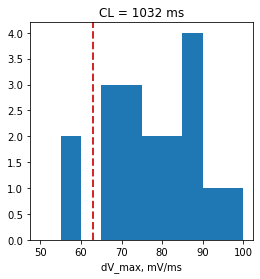

In [134]:
plt.figure(figsize=plt.figaspect(1))

plt.hist(dV_list, bins=list(range(50, 101, 5)))
plt.axvline(63, color='C3', ls='--', lw=2)

plt.xlabel('dV_max, mV/ms')
plt.title('CL = 1032 ms')
plt.savefig("./images/koivumaki/dV_max_voigt.png", dpi=300)

In [169]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%y%m%d_%H%M%S")
print("date and time =", dt_string)	


now = 2020-12-02 22:57:51.774292
date and time = 201202_225751


In [178]:
os.makedirs("test", exist_ok=True)

In [582]:
#

In [597]:
df = pd.read_csv("../src/model_ctypes/_maleckar_tor/legend_constants.csv")

In [601]:
for i in range(len(df)):
    line = f"CONSTANTS[{i}]\t= {df['value'].iloc[i]:.6e};\t//  {df['name'].iloc[i]}\n"
    print(line, end='')

CONSTANTS[0]	= 8.314000e+03;	//  R
CONSTANTS[1]	= 3.061500e+02;	//  T
CONSTANTS[2]	= 9.648700e+04;	//  F
CONSTANTS[3]	= 5.000000e+01;	//  Cm
CONSTANTS[4]	= 0.000000e+00;	//  stim_offset
CONSTANTS[5]	= 1.000000e+00;	//  stim_period
CONSTANTS[6]	= 6.000000e-03;	//  stim_duration
CONSTANTS[7]	= -1.500000e+01;	//  stim_amplitude
CONSTANTS[8]	= 1.800000e-03;	//  P_Na
CONSTANTS[9]	= 6.750000e+00;	//  g_Ca_L
CONSTANTS[10]	= 6.000000e+01;	//  E_Ca_app
CONSTANTS[11]	= 2.500000e-02;	//  k_Ca
CONSTANTS[12]	= 8.250000e+00;	//  g_t
CONSTANTS[13]	= 2.250000e+00;	//  g_kur
CONSTANTS[14]	= 3.100000e+00;	//  g_K1
CONSTANTS[15]	= 1.000000e+00;	//  g_Ks
CONSTANTS[16]	= 5.000000e-01;	//  g_Kr
CONSTANTS[17]	= 6.059900e-02;	//  g_B_Na
CONSTANTS[18]	= 7.868100e-02;	//  g_B_Ca
CONSTANTS[19]	= 1.000000e+00;	//  K_NaK_K
CONSTANTS[20]	= 6.855000e+01;	//  i_NaK_max
CONSTANTS[21]	= 3.648290e+01;	//  pow_K_NaK_Na_15
CONSTANTS[22]	= 4.000000e+00;	//  i_CaP_max
CONSTANTS[23]	= 2.000000e-04;	//  k_CaP
CONSTANTS[24]	= 

In [589]:
df

,name,value,component,units
0,V,-74.031982,membrane,millivolt
1,Na_c,130.022096,cleft_space_ion_concentrations,millimolar
2,Na_i,8.516766,intracellular_ion_concentrations,millimolar
3,m,0.003289,sodium_current_m_gate,dimensionless
4,h1,0.877202,sodium_current_h1_gate,dimensionless
5,h2,0.873881,sodium_current_h2_gate,dimensionless
6,Ca_d,0.000071,intracellular_ion_concentrations,millimolar
7,d_L,0.000014,L_type_Ca_channel_d_L_gate,dimensionless
8,f_L1,0.998597,L_type_Ca_channel_f_L1_gate,dimensionless
9,f_L2,0.998586,L_type_Ca_channel_f_L2_gate,dimensionless


# Rheeda (8 Jan)

In [213]:
columns = ['t', 'v', 'ist']

df_rheeda_norm = pd.DataFrame(np.loadtxt("../../../projects/Rheeda/G3C1/output_grp2.txt"), columns=columns)
df_rheeda_fibr = pd.DataFrame(np.loadtxt("../../../projects/Rheeda/G3C1/output_grp2fib.txt"), columns=columns)

In [214]:
df_rheeda_norm.to_csv("../../../projects/Rheeda/G3C1/output_grp2.csv", index=False)
df_rheeda_fibr.to_csv("../../../projects/Rheeda/G3C1/output_grp2fib.csv", index=False)

In [215]:
df_andrey_norm = pd.read_csv("../../../projects/Rheeda/G3C1/andrey_normal.csv")
df_andrey_fibr = pd.read_csv("../../../projects/Rheeda/G3C1/andrey_fibrosis.csv")

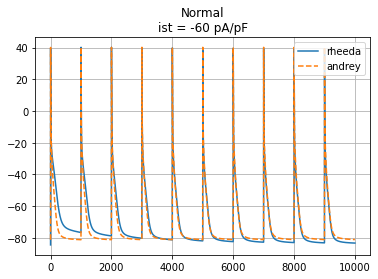

In [223]:
plt.plot(df_rheeda_norm.t, df_rheeda_norm.v, label='rheeda')
plt.plot(df_andrey_norm.V, '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Normal\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/normal.png", dpi=300)

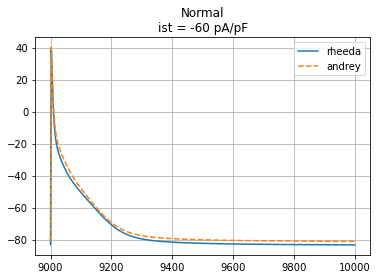

In [224]:
plt.plot(df_rheeda_norm.t[-1001:], df_rheeda_norm.v[-1001:], label='rheeda')
plt.plot(df_andrey_norm.V[-1001:], '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Normal\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/normal_one_beat.png", dpi=300)

In [248]:
pc.signal.analysis.calculate_APD(df_rheeda_norm.t[-1001:], df_rheeda_norm.v[-1001:])

139.0

In [251]:
pc.signal.analysis.calculate_APD(df_rheeda_norm.t[-1001:], df_andrey_norm.V[-1001:])

137.0

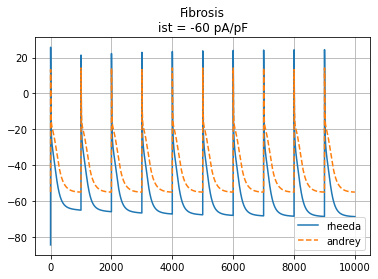

In [225]:
plt.plot(df_rheeda_fibr.t, df_rheeda_fibr.v, label='rheeda')
plt.plot(df_andrey_fibr.V, '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Fibrosis\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/fibrosis.png", dpi=300)

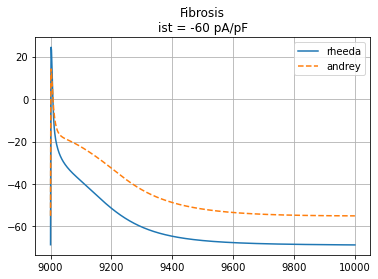

In [226]:
plt.plot(df_rheeda_fibr.t[-1001:], df_rheeda_fibr.v[-1001:], label='rheeda')
plt.plot(df_andrey_fibr.V[-1001:], '--', label='andrey')

plt.grid()
plt.legend()

plt.title("Fibrosis\nist = -60 pA/pF")

plt.savefig("../../../projects/Rheeda/G3C1/images/fibrosis_one_beat.png", dpi=300)

In [231]:
%matplotlib inline

(-10.0, 100.0)

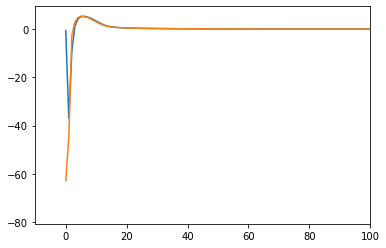

In [238]:
plt.plot(df_rheeda_fibr.ist)
plt.plot(-np.diff(df_rheeda_fibr.v))

plt.xlim(-10, 100)

In [189]:
df_rheeda_norm[:1]

,t,v,ist
0,0.0,-84.471006,-0.394154


In [190]:
df_andrey_norm

,V,Na_c,Na_i,m,h1,h2,Ca_d,d_L,f_L1,f_L2,...,O_C,O_TC,O_TMgC,O_TMgMg,O,Ca_rel,Ca_up,O_Calse,F1,F2
0,-81.229237,139.959082,8.273438,0.001371,0.965157,0.963456,0.000027,0.000004,0.999490,0.999484,...,0.010674,0.005109,0.164216,0.626991,1.376686,0.267990,0.267668,0.243337,0.550704,0.000126
1,-11.296079,139.953183,8.274240,0.694911,0.758430,0.930072,0.000033,0.005504,0.995640,0.998945,...,0.010766,0.005147,0.164227,0.626992,1.376695,0.267990,0.268026,0.243336,0.551065,0.000126
2,40.123775,139.921676,8.278526,0.999719,0.027176,0.666546,0.001429,0.372836,0.901868,0.983295,...,0.011210,0.005330,0.164339,0.626937,1.376748,0.268003,0.269983,0.243337,0.551198,0.000354
3,38.355507,139.921817,8.278507,0.999661,0.000969,0.477601,0.003759,0.619014,0.816051,0.967713,...,0.011748,0.005562,0.164518,0.626824,1.376819,0.266207,0.272893,0.243215,0.546261,0.005582
4,32.566485,139.922800,8.278374,0.999317,0.000035,0.342216,0.006372,0.768093,0.738407,0.952380,...,0.014657,0.006763,0.165326,0.626458,1.377175,0.239351,0.285183,0.239744,0.529649,0.022121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,-81.098091,139.950872,8.278398,0.001393,0.964304,0.962204,0.000027,0.000004,0.999480,0.999476,...,0.010735,0.005139,0.165219,0.626239,1.376852,0.269205,0.269176,0.244170,0.537400,0.000125
9997,-81.098943,139.950877,8.278398,0.001393,0.964310,0.962223,0.000027,0.000004,0.999480,0.999476,...,0.010734,0.005139,0.165205,0.626249,1.376850,0.269204,0.269164,0.244169,0.537772,0.000125
9998,-81.099793,139.950882,8.278398,0.001393,0.964316,0.962241,0.000027,0.000004,0.999481,0.999476,...,0.010734,0.005138,0.165192,0.626259,1.376848,0.269204,0.269153,0.244168,0.538145,0.000125
9999,-81.100642,139.950888,8.278398,0.001393,0.964322,0.962259,0.000027,0.000004,0.999481,0.999476,...,0.010733,0.005138,0.165179,0.626269,1.376845,0.269203,0.269141,0.244168,0.538516,0.000125
